## 1. Problem Setup
### The Allen-Cahn Equation
This notebook demonstrates learning the operator for the **Allen-Cahn equation**, a reaction-diffusion PDE:

$$
\frac{\partial u}{\partial t} = D \Delta u + u - u^3, \quad x \in [0, 1]^2, \quad t \in [0, T]
$$

where $u(x, t)$ is the order parameter and $D$ is the diffusion coefficient.

### Objective
We aim to learn the operator $\mathcal{G}: u(x, 0) \mapsto u(x, t)$ using a **DeepONet**.

Import necessary libraries.

In [10]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn import gaussian_process as gp
from scipy.fft import fft2, ifft2

# Set random seeds for reproducibility
np.random.seed(89757)
torch.manual_seed(89757)

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Data Generation

### Numerical Solver: Pseudo-Spectral IMEX
We generate training data using a **Pseudo-Spectral method** with an **Implicit-Explicit (IMEX)** time-stepping scheme:

1.  **Linear Term ($D \Delta u$)**: Handled implicitly in Fourier space to allow larger time steps.
2.  **Non-linear Term ($u - u^3$)**: Handled explicitly in real space.

The update rule in Fourier space is:
$$
\hat{u}^{n+1} = \frac{\hat{u}^n + \Delta t \cdot \mathcal{F}(u^n - (u^n)^3)}{1 + \Delta t \cdot D |k|^2}
$$

**Note on Aliasing**: This implementation uses a standard grid without 3/2 padding (de-aliasing). For rigorous scientific simulations, de-aliasing is recommended to prevent energy pile-up at high frequencies, but for this deep learning demonstration, it is sufficient.

The initial conditions are drawn from a **Gaussian Random Field (GRF)**.

In [11]:
class GRF2D:
    def __init__(self, shape, length_scale=0.1, Lx=1.0, Ly=1.0):
        self.shape = shape
        self.length_scale = length_scale
        x = np.linspace(0, Lx, shape[0])
        y = np.linspace(0, Ly, shape[1])
        xx, yy = np.meshgrid(x, y)
        self.coords = np.vstack([xx.ravel(), yy.ravel()]).T
        kernel = gp.kernels.RBF(length_scale=self.length_scale)
        self.K = kernel(self.coords)
        self.L = np.linalg.cholesky(self.K + 1e-9 * np.eye(self.K.shape[0]))

    def random(self, n):
        u = np.random.randn(self.K.shape[0], n)
        samples = np.dot(self.L, u).T
        return samples.reshape((n,) + self.shape)

In [12]:
def solve_allen_cahn_2d_spectral(u0, D, dt, T, Lx=1.0, Ly=1.0):
    """
    Solves the 2D Allen-Cahn equation using a pseudo-spectral method
    with an IMEX (implicit-explicit) time-stepping scheme.
    u_t = D * laplacian(u) + u - u^3
    """
    Nx, Ny = u0.shape
    t = np.arange(0, T, dt)
    Nt = len(t)

    # Wavenumbers
    kx = (2 * np.pi / Lx) * np.fft.fftfreq(Nx, 1/Nx)
    ky = (2 * np.pi / Ly) * np.fft.fftfreq(Ny, 1/Ny)
    Kx, Ky = np.meshgrid(kx, ky)
    K2 = Kx**2 + Ky**2
    
    # Store solution in time
    u_t = np.zeros((Nt, Nx, Ny))
    u_t[0, :, :] = u0
    
    u_hat = np.fft.fft2(u0)
    
    # Denominator for the implicit diffusion term
    denominator = 1 + dt * D * K2

    for i in range(1, Nt):
        u = np.fft.ifft2(u_hat).real
        reaction_hat = np.fft.fft2(u - u**3)
        
        # Update in Fourier space
        u_hat = (u_hat + dt * reaction_hat) / denominator
        
        # Store real space solution
        u_t[i, :, :] = np.fft.ifft2(u_hat).real
        
    return u_t, t

In [13]:
def generate_allen_cahn_data(grf, D, dt, T, num_samples, num_points_output, Lx=1.0, Ly=1.0):
    # Generate initial conditions
    u0s = grf.random(num_samples)
    
    # Solve PDE for each initial condition
    solutions = []
    for u0 in u0s:
        sol, t_steps = solve_allen_cahn_2d_spectral(u0, D, dt, T, Lx=Lx, Ly=Ly)
        solutions.append(sol)
    solutions = np.array(solutions) # (num_samples, Nt, Nx, Ny)
    
    Nt, Nx, Ny = solutions.shape[1:]

    # Prepare data for DeepONet
    # Input for branch net: initial condition u0, flattened
    X_u = u0s.reshape(num_samples, -1)
    
    # Input for trunk net: coordinates (x, y, t)
    # Output: solution u(x, y, t)
    
    X_y = []
    Y = []
    
    for i in range(num_samples):
        # Sample random points in space and time
        x_indices = np.random.randint(0, Nx, num_points_output)
        y_indices = np.random.randint(0, Ny, num_points_output)
        t_indices = np.random.randint(0, Nt, num_points_output)
        
        # Coordinates for trunk net
        coords_x = x_indices / (Nx - 1.0)
        coords_y = y_indices / (Ny - 1.0)
        coords_t = t_steps[t_indices] / T
        
        y_sample = np.vstack([coords_x, coords_y, coords_t]).T
        X_y.append(y_sample)
        
        # Corresponding solution values
        output_sample = solutions[i, t_indices, x_indices, y_indices]
        Y.append(output_sample[:, np.newaxis])

    return np.array(X_u), np.array(X_y), np.array(Y)

## 3. DeepONet Model Definition

### Deep Operator Network (DeepONet)
DeepONet learns a mapping from input functions to output functions via two subnetworks:
1.  **Branch Network**: Encodes the input function $u_0(\cdot)$ (discretized at sensors).
2.  **Trunk Network**: Encodes the query locations $(x, y, t)$.

### Modified DeepONet Architecture
Here we implement a variation called **Modified DeepONet**:
*   Instead of a simple dot product, the outputs of Branch and Trunk are combined via **element-wise multiplication**.
*   The result is processed by a final linear layer (`self.fc`) to produce the scalar output.
*   This architecture often shows improved convergence and accuracy over the vanilla dot-product DeepONet.

$$
G(u)(y) \approx \text{Linear}(\text{Branch}(u) \odot \text{Trunk}(y))
$$

In [14]:
class MLP(nn.Module):
    def __init__(self,in_features : int,out_features: int,hidden_features: int,num_hidden_layers: int) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_features,hidden_features)
        self.linear_out = nn.Linear(hidden_features,out_features)
        self.activation = torch.tanh
        self.layers = nn.ModuleList([self.linear_in] + [nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)  ])
        self.norm_layers = nn.ModuleList([nn.LayerNorm(hidden_features) for _ in range(num_hidden_layers+1)])
         
    def forward(self,x):
        for i, layer in enumerate(self.layers):
            x = self.activation(self.norm_layers[i](layer(x)))
        return self.linear_out(x)

In [15]:
class DeepONet(nn.Module):
    def __init__(self,latent_features,out_features,branch,trunk) -> None:
        super().__init__()
        self.branch = branch
        self.trunk = trunk
        self.fc = nn.Linear(latent_features,out_features)

    def forward(self,u,y):
        branch_out = torch.tanh(self.branch(u))
        trunk_out = torch.tanh(self.trunk(y))
        branch_out = branch_out.unsqueeze(1)
        return self.fc(branch_out*trunk_out)

## 4. Training and Testing
We define a custom dataset and set up the training and testing loop.

In [16]:
class Onet_dataset(Dataset):
    def __init__(self,u,y,Guy):
        self.u = u
        self.y = y
        self.Guy = Guy
        
    def __len__(self):
        return len(self.u)

    def __getitem__(self,idx):
        return self.u[idx],self.y[idx],self.Guy[idx]

In [17]:
# Parameters
Nx, Ny = 32, 32
Lx, Ly = 2, 2 # Domain size
D = 0.01
dt = 0.01
T = 3.0
num_train = 2000
num_test = 400
num_points_output = 1000
m = Nx * Ny # number of input sensors for branch net

# Data generation
print("Generating training data...")
grf = GRF2D(shape=(Nx, Ny), length_scale=0.2, Lx=Lx, Ly=Ly)
X_u_train, X_y_train, y_train = generate_allen_cahn_data(grf, D, dt, T, num_train, num_points_output, Lx=Lx, Ly=Ly)
print("Generating testing data...")
X_u_test, X_y_test, y_test = generate_allen_cahn_data(grf, D, dt, T, num_test, num_points_output, Lx=Lx, Ly=Ly)

# Create datasets and dataloaders
train_dataset = Onet_dataset(torch.from_numpy(X_u_train).float(), torch.from_numpy(X_y_train).float(), torch.from_numpy(y_train).float())
test_dataset = Onet_dataset(torch.from_numpy(X_u_test).float(), torch.from_numpy(X_y_test).float(), torch.from_numpy(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
latent_dim = 256
feature_dim = 256
branch_net = MLP(in_features=m, out_features=latent_dim, hidden_features=feature_dim, num_hidden_layers=3)
trunk_net = MLP(in_features=3, out_features=latent_dim, hidden_features=feature_dim, num_hidden_layers=3) # Trunk input is (x, y, t)
onet = DeepONet(latent_features=latent_dim, out_features=1, branch=branch_net, trunk=trunk_net)
onet.to(device)

# Training loop
optimizer = Adam(onet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
epochs = 1000
criterion = nn.MSELoss()

print("Starting training...")
for epoch in range(epochs):
    onet.train()
    epoch_loss = 0
    for u, y, Guy in train_loader:
        u, y, Guy = u.to(device), y.to(device), Guy.to(device)
        optimizer.zero_grad()
        out = onet(u, y)
        loss = criterion(out, Guy)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    onet.eval()
    val_loss = 0
    with torch.no_grad():
        for u, y, Guy in test_loader:
            u, y, Guy = u.to(device), y.to(device), Guy.to(device)
            out = onet(u, y)
            val_loss += criterion(out, Guy).item()
    
    val_loss /= len(test_loader)
    train_loss = epoch_loss/len(train_loader)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

# Testing
print("Starting testing...")
onet.eval()
test_loss = 0
with torch.no_grad():
    for u, y, Guy in test_loader:
        u, y, Guy = u.to(device), y.to(device), Guy.to(device)
        out = onet(u, y)
        test_loss += criterion(out, Guy).item()
print(f"Test MSE: {test_loss/len(test_loader)}")

# Save the trained model
torch.save(onet.state_dict(), 'allen_cahn_deeponet.pth')
print("Model saved to allen_cahn_deeponet.pth")

Generating training data...
Generating testing data...
Starting training...
Epoch 10/1000, Train Loss: 0.111492, Validation Loss: 0.120292
Epoch 20/1000, Train Loss: 0.070081, Validation Loss: 0.082539
Epoch 30/1000, Train Loss: 0.054105, Validation Loss: 0.068527
Epoch 40/1000, Train Loss: 0.046952, Validation Loss: 0.061446
Epoch 50/1000, Train Loss: 0.040635, Validation Loss: 0.055741
Epoch 60/1000, Train Loss: 0.037675, Validation Loss: 0.050156
Epoch 70/1000, Train Loss: 0.033493, Validation Loss: 0.048254
Epoch 80/1000, Train Loss: 0.030855, Validation Loss: 0.045898
Epoch 90/1000, Train Loss: 0.029062, Validation Loss: 0.043161
Epoch 100/1000, Train Loss: 0.028115, Validation Loss: 0.042787
Epoch 110/1000, Train Loss: 0.028485, Validation Loss: 0.042002
Epoch 120/1000, Train Loss: 0.024777, Validation Loss: 0.040087
Epoch 130/1000, Train Loss: 0.025271, Validation Loss: 0.039156
Epoch 140/1000, Train Loss: 0.023613, Validation Loss: 0.038332
Epoch 150/1000, Train Loss: 0.022872,

## 5. Visualization
We visualize the performance of the trained DeepONet by comparing its predictions to the numerical solution for a sample from the test set.

Generating true solution for visualization...


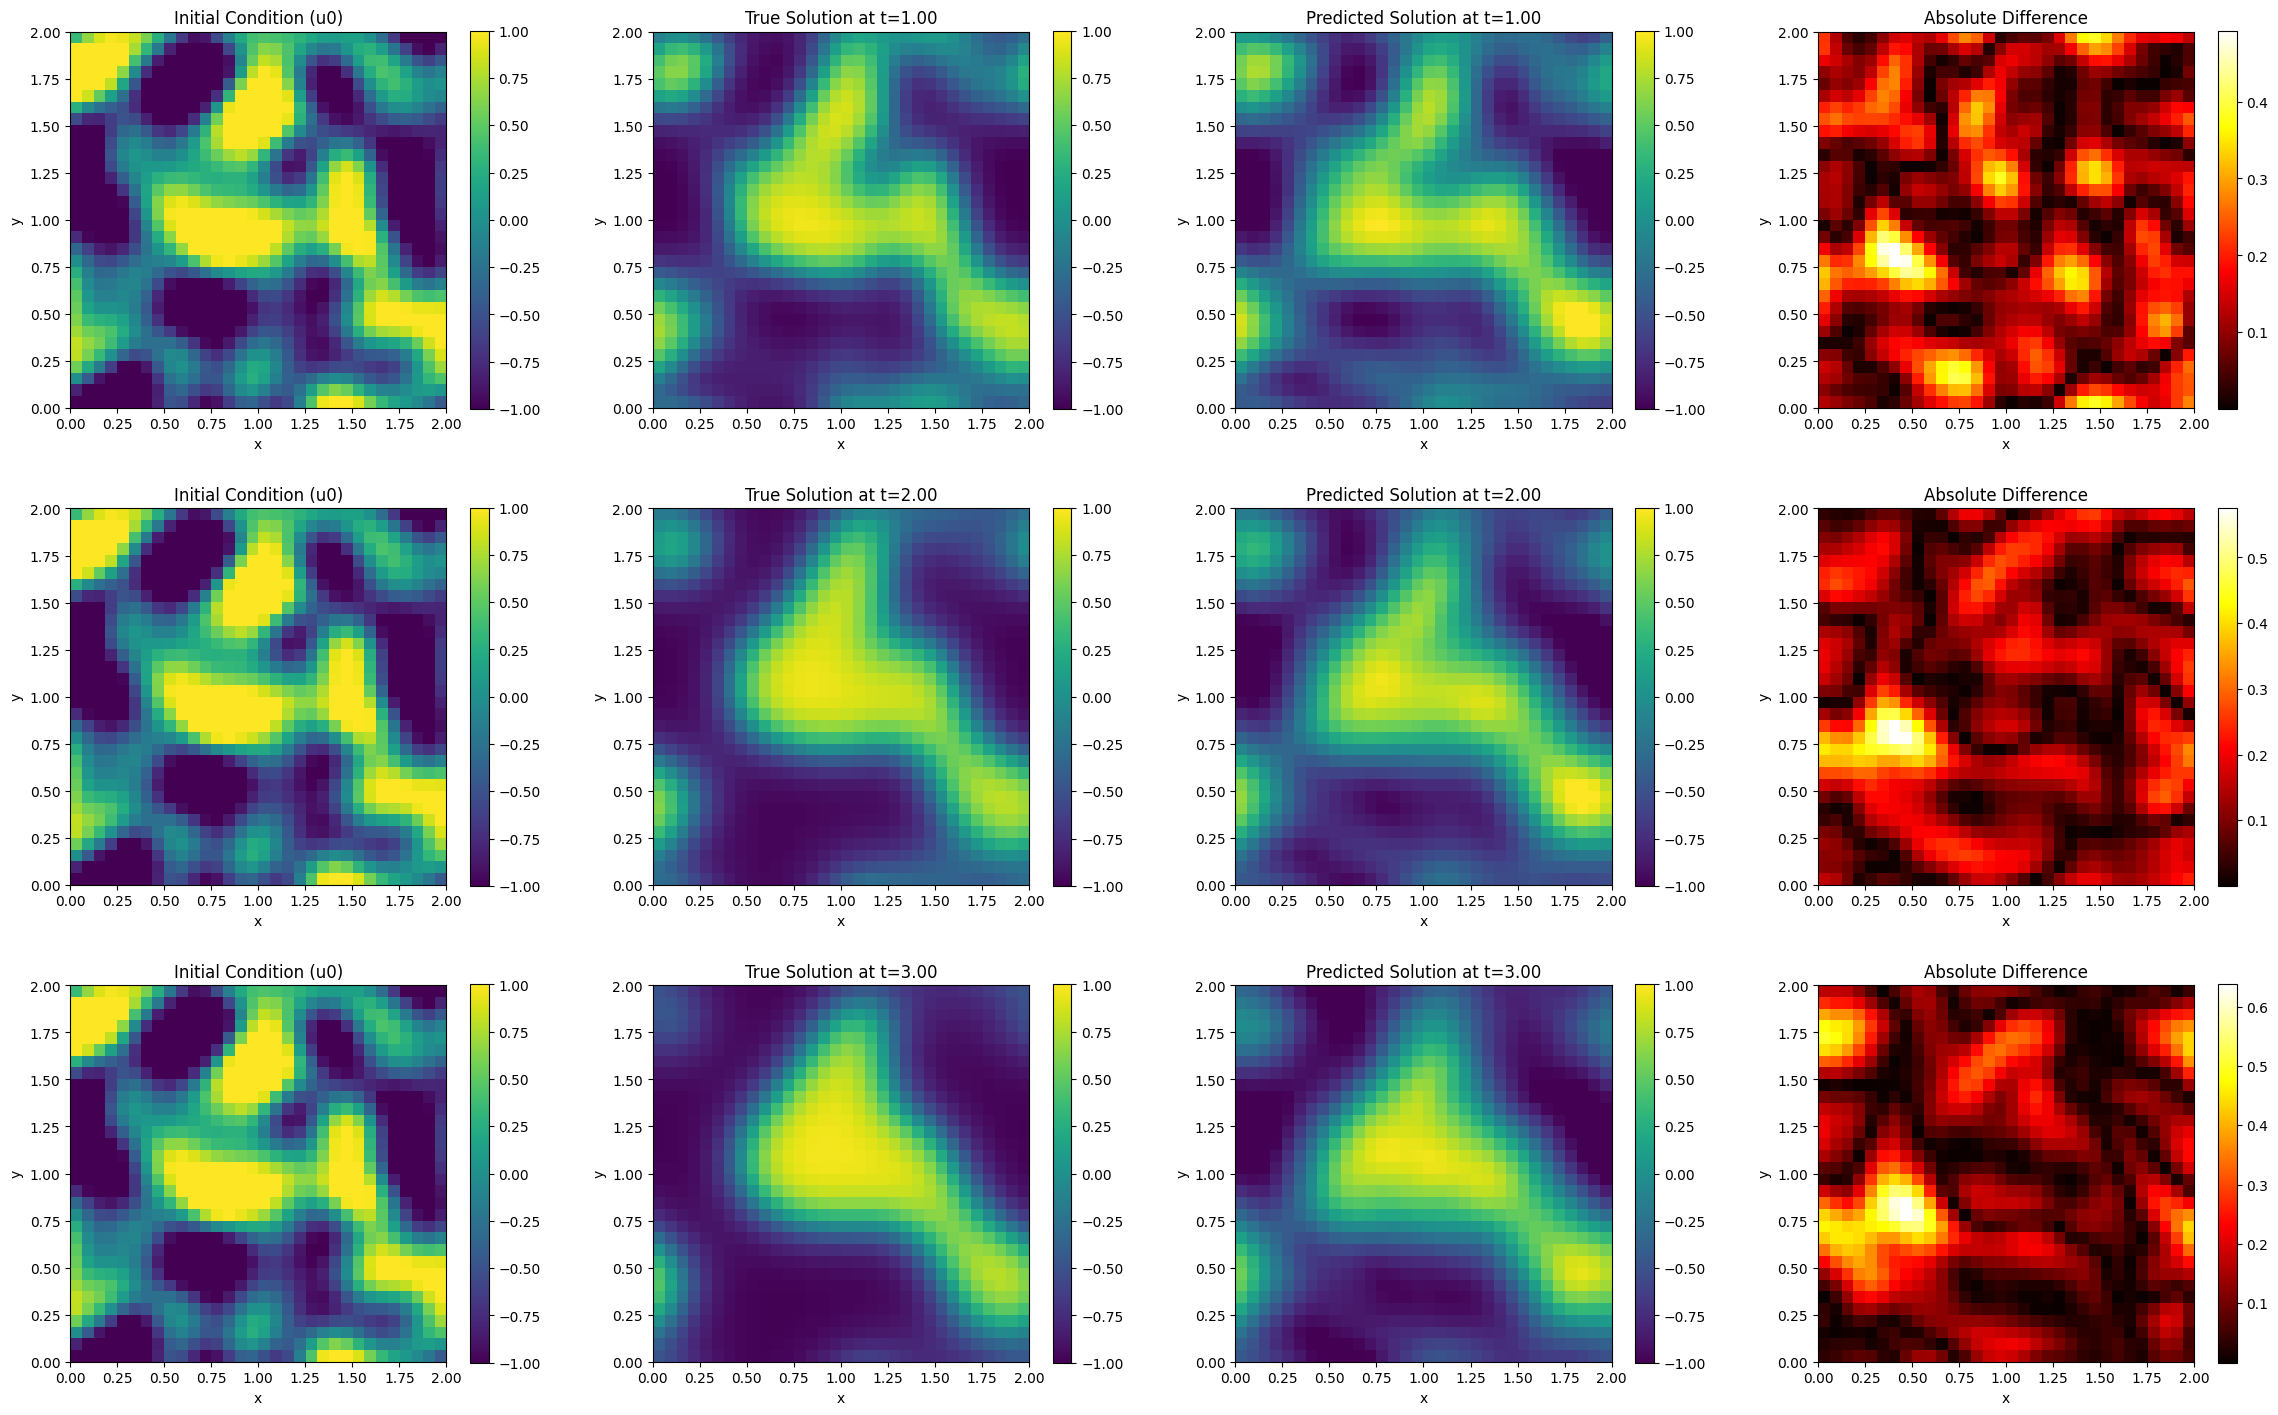

In [20]:
# Select a sample from the test set
test_sample_idx = 0
u0_test = X_u_test[test_sample_idx].reshape(Nx, Ny)
u_branch = torch.from_numpy(X_u_test[test_sample_idx]).float().unsqueeze(0).to(device)

# Generate true solution for this u0
print("Generating true solution for visualization...")
true_solution, t_steps = solve_allen_cahn_2d_spectral(u0_test, D, dt, T, Lx=Lx, Ly=Ly)

# Create a grid for prediction
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
xx, yy = np.meshgrid(x, y)
grid_x = xx.ravel()
grid_y = yy.ravel()

# Visualize at a few time steps
time_points_to_plot = [1.0, 2.0, 3.0]

fig, axes = plt.subplots(len(time_points_to_plot), 4, figsize=(24, 5 * len(time_points_to_plot)))
fig.tight_layout(pad=5.0)

onet.eval()
for i, t_plot in enumerate(time_points_to_plot):
    # Prepare trunk input for this time step
    t_normalized = t_plot / T
    grid_t = np.full_like(grid_x, t_normalized)
    y_trunk = torch.from_numpy(np.vstack([grid_x / Lx, grid_y / Ly, grid_t]).T).float().unsqueeze(0).to(device)
    
    # Predict with DeepONet
    with torch.no_grad():
        pred_solution_flat = onet(u_branch, y_trunk).squeeze().cpu().numpy()
    pred_solution = pred_solution_flat.reshape(Ny, Nx).T
    
    # Get true solution at this time step
    t_idx = np.argmin(np.abs(t_steps - t_plot))
    true_sol_t = true_solution[t_idx]
    
    # Plotting
    # Initial Condition
    ax = axes[i, 0]
    im = ax.imshow(u0_test, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    ax.set_title('Initial Condition (u0)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # True Solution
    ax = axes[i, 1]
    im = ax.imshow(true_sol_t, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    ax.set_title(f'True Solution at t={t_plot:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Predicted Solution
    ax = axes[i, 2]
    im = ax.imshow(pred_solution, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax)
    ax.set_title(f'Predicted Solution at t={t_plot:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Difference
    ax = axes[i, 3]
    diff = np.abs(true_sol_t - pred_solution)
    im = ax.imshow(diff, cmap='hot', extent=[0, Lx, 0, Ly], origin='lower')
    plt.colorbar(im, ax=ax)
    ax.set_title('Absolute Difference')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.show()

## 6. Load Model and Predict with a New Initial Condition
Now we'll load the saved model and test its performance on a completely new initial condition that it has never seen before.

Model loaded from allen_cahn_deeponet.pth
Processing initial condition 1/3...
Processing initial condition 2/3...
Processing initial condition 3/3...


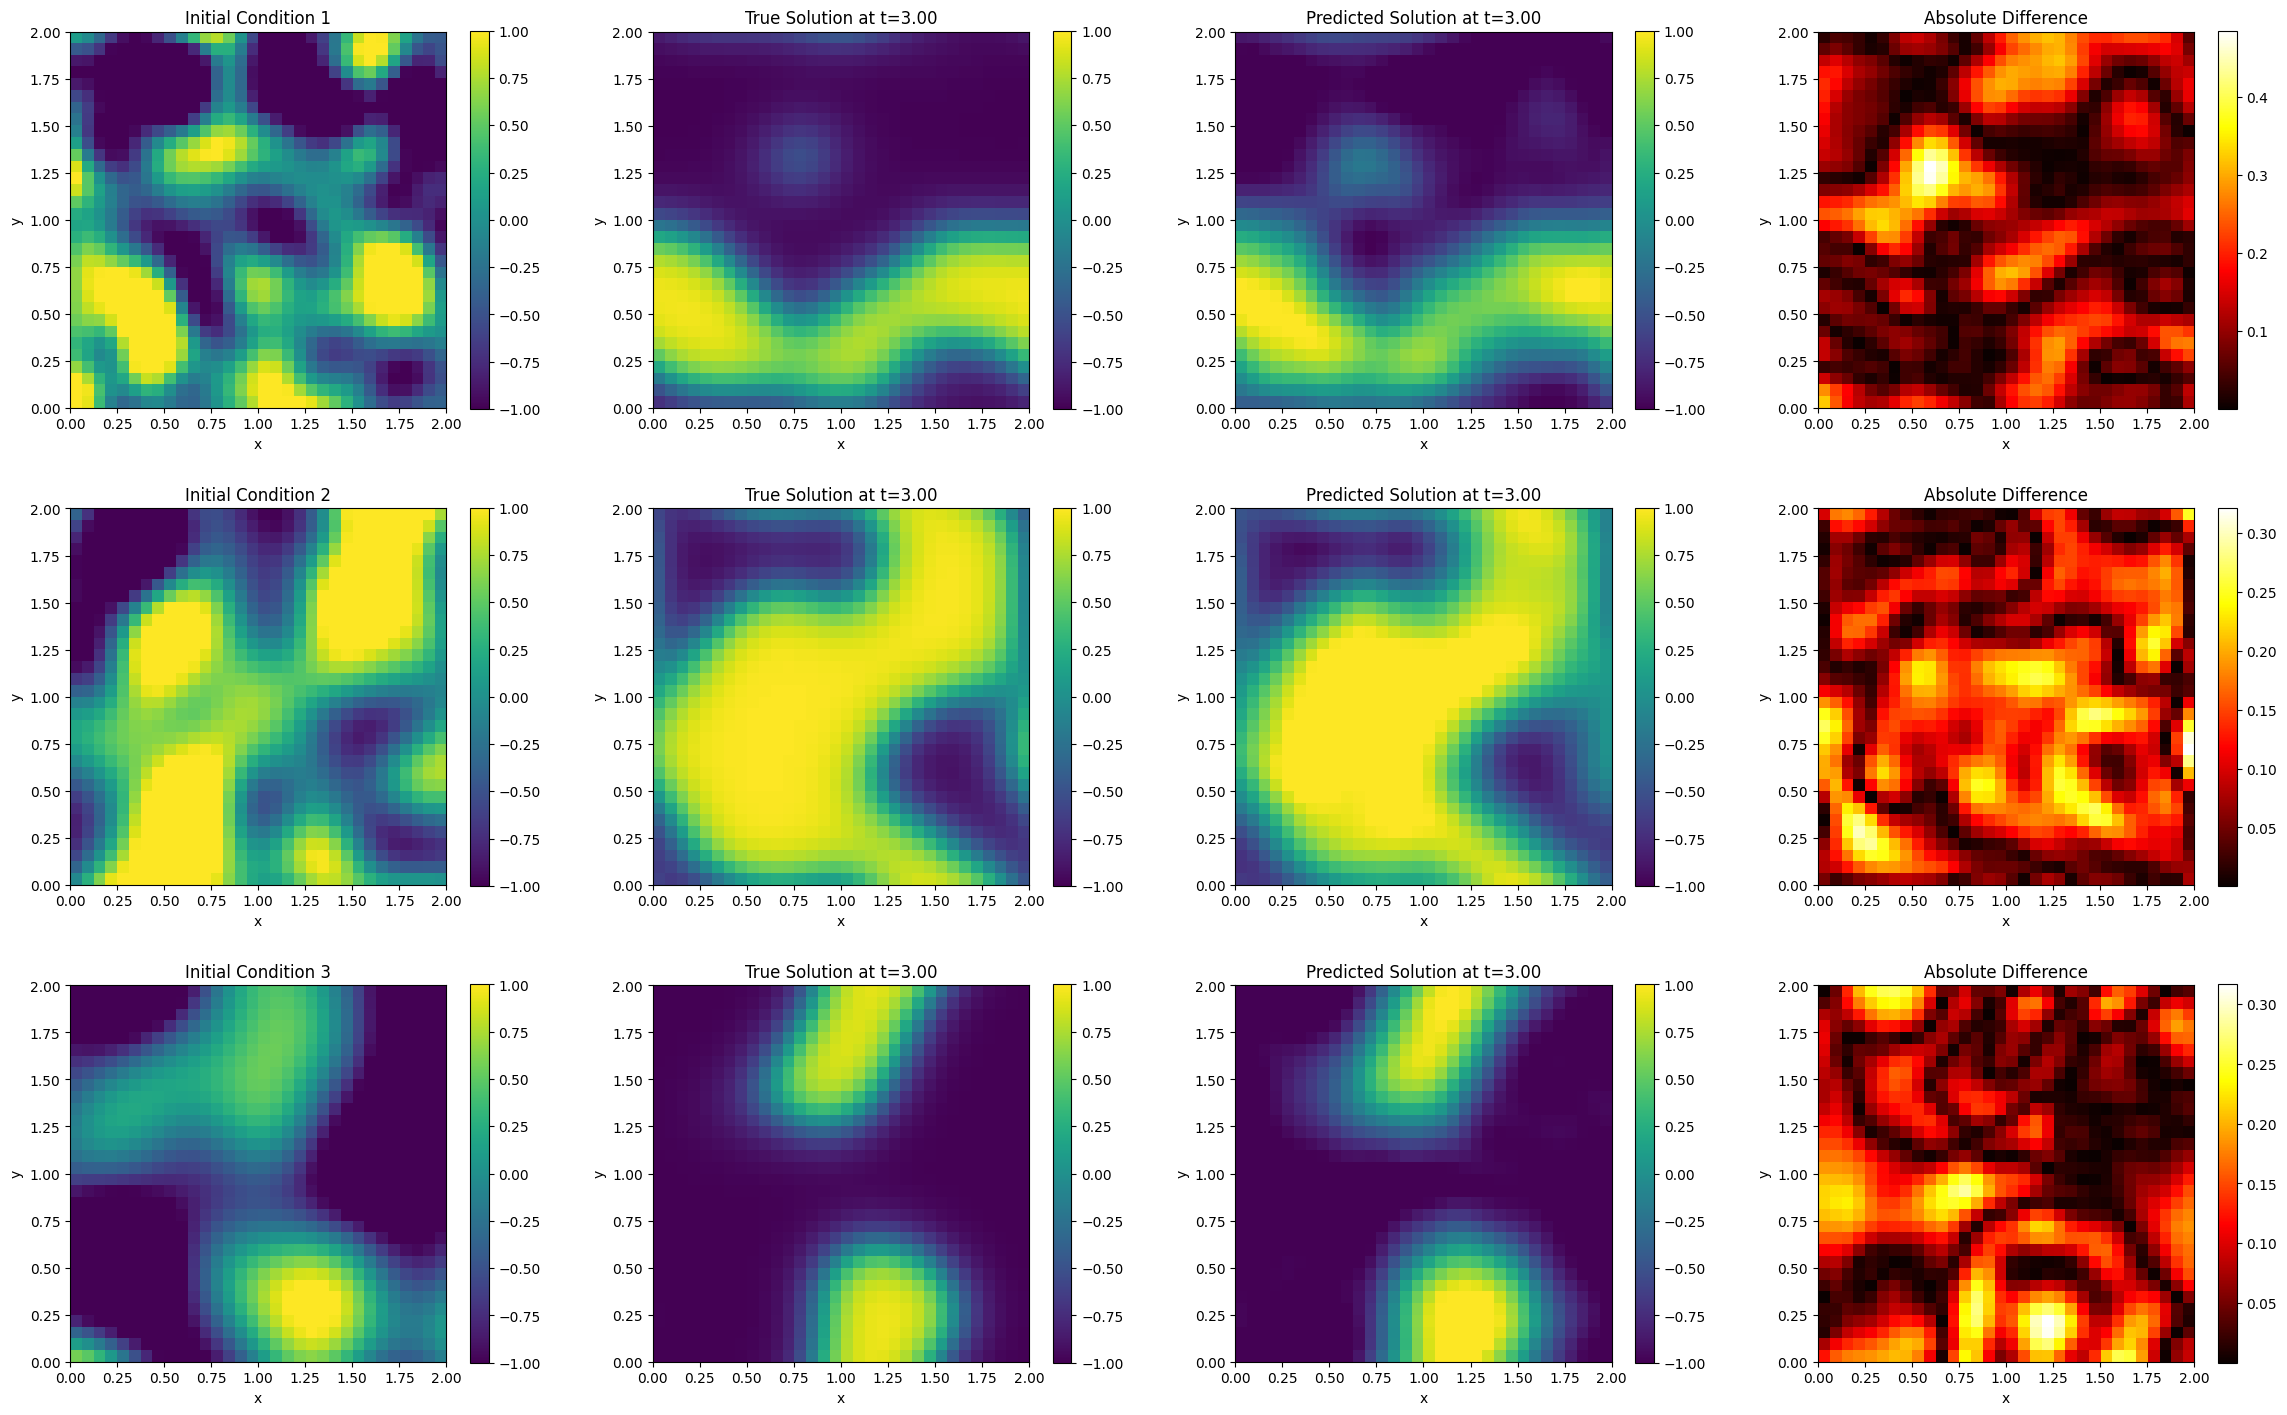

In [23]:
# 1. Re-initialize the model architecture
branch_net_loaded = MLP(in_features=m, out_features=latent_dim, hidden_features=feature_dim, num_hidden_layers=3)
trunk_net_loaded = MLP(in_features=3, out_features=latent_dim, hidden_features=feature_dim, num_hidden_layers=3)
onet_loaded = DeepONet(latent_features=latent_dim, out_features=1, branch=branch_net_loaded, trunk=trunk_net_loaded)
onet_loaded.to(device)

# 2. Load the saved state dictionary
onet_loaded.load_state_dict(torch.load('allen_cahn_deeponet.pth'))
onet_loaded.eval()
print("Model loaded from allen_cahn_deeponet.pth")

# 3. Define plotting parameters
num_initial_conditions = 3
t_plot = 3.0

# 4. Set up the plot grid
fig, axes = plt.subplots(num_initial_conditions, 4, figsize=(24, 5 * num_initial_conditions))
fig.tight_layout(pad=5.0)

# 5. Loop through different initial conditions
for i in range(num_initial_conditions):
    print(f"Processing initial condition {i+1}/{num_initial_conditions}...")
    
    # Generate a new, different initial condition
    grf_new = GRF2D(shape=(Nx, Ny), length_scale=0.2 + i * 0.1, Lx=Lx, Ly=Ly) # Vary length_scale for diversity
    u0_new = grf_new.random(1)[0]
    u_branch_new = torch.from_numpy(u0_new.flatten()).float().unsqueeze(0).to(device)

    # Solve for the "true" solution for this new condition
    true_solution_new, t_steps_new = solve_allen_cahn_2d_spectral(u0_new, D, dt, T, Lx=Lx, Ly=Ly)
    t_idx = np.argmin(np.abs(t_steps_new - t_plot))
    true_sol_t_new = true_solution_new[t_idx]

    # Prepare trunk input for the specified time step
    t_normalized = t_plot / T
    grid_t = np.full_like(grid_x, t_normalized)
    y_trunk = torch.from_numpy(np.vstack([grid_x / Lx, grid_y / Ly, grid_t]).T).float().unsqueeze(0).to(device)
    
    # Predict with the loaded DeepONet
    with torch.no_grad():
        pred_solution_flat = onet_loaded(u_branch_new, y_trunk).squeeze().cpu().numpy()
    pred_solution_new = pred_solution_flat.reshape(Ny, Nx).T

    # --- Plotting ---
    
    # Plot Initial Condition
    ax = axes[i, 0]
    im = ax.imshow(u0_new, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    ax.set_title(f'Initial Condition {i+1}')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plot True Solution
    ax = axes[i, 1]
    im = ax.imshow(true_sol_t_new, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    ax.set_title(f'True Solution at t={t_plot:.2f}')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plot Predicted Solution
    ax = axes[i, 2]
    im = ax.imshow(pred_solution_new, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower', vmin=-1, vmax=1)
    ax.set_title(f'Predicted Solution at t={t_plot:.2f}')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Plot Difference
    ax = axes[i, 3]
    diff = np.abs(true_sol_t_new - pred_solution_new)
    im = ax.imshow(diff, cmap='hot', extent=[0, Lx, 0, Ly], origin='lower')
    ax.set_title('Absolute Difference')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')


plt.show()